In [0]:
import tensorflow as tf

In [0]:
# To generate GIF:

!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import time

from IPython import display

In [0]:
# load and prepare data:

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 #normalize images to [-1, 1]

In [0]:
BUFFER_SIZE = 600000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# Building the Generator:

def make_generator_model():
  
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # None: Batch Size

  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
                                            use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                                            use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                            use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

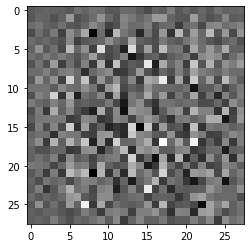

In [44]:
# Create image:

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
# Build the Discriminator:

def make_discriminator_model():

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                   input_shape=[28, 28, 1]))
  
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [46]:
# Discriminating:

discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00441534]], shape=(1, 1), dtype=float32)


In [0]:
# Loss Function:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Fake or not Fake

In [0]:
# Qualifying the discriminator:

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [0]:
# Generator Loss:

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Optmizers from Discriminator and Generator: (Different)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# Saving Checkpoints:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Train Loop:

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs + 1, seed)

    # Save the model every 15 epochs:

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    #Generate after the final epoch:

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
# Generate and Save Images:

def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 125.5, cmap='gray')
    plt.axis=('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

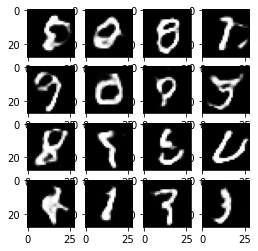

In [81]:
# Train the model:

train(train_dataset, EPOCHS)

In [82]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display single image:

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

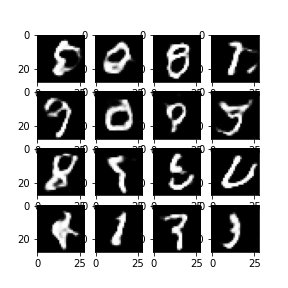

In [86]:
display_image(EPOCHS)

In [0]:
# Generate GIF:

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  last = -1

  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)

    if round(frame) > round(last):
      last = frame
    else:
      continue

    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6, 2, 0, ''):
  display.Image(filename=anim_file)

In [0]:
# Download:

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)